[View in Colaboratory](https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/nlp/3-gru-dropout.ipynb)

In [0]:
# Based on
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
import pandas as pd
print(pd.__version__)

0.22.0


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.11.0-rc2


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


In [0]:
# https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
max_features = 10000  # number of words to consider as features
maxlen = 500  # cut texts after this number of words (among top max_features most common words)

# each review is encoded as a sequence of word indexes
# indexed by overall frequency in the dataset
# output is 0 (negative) or 1 (positive) 
imdb = tf.keras.datasets.imdb.load_data(num_words=max_features)
(raw_input_train, y_train), (raw_input_test, y_test) = imdb

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

input_train = tf.keras.preprocessing.sequence.pad_sequences(raw_input_train, maxlen=maxlen)
input_test = tf.keras.preprocessing.sequence.pad_sequences(raw_input_test, maxlen=maxlen)

In [10]:
input_train.shape, input_test.shape, y_train.shape, y_test.shape

((25000, 500), (25000, 500), (25000,), (25000,))

## GRU

In [0]:
# tf.keras.layers.GRU?

In [12]:
# Batch Normalization:
# https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c
# https://www.quora.com/Why-does-batch-normalization-help

embedding_dim = 32
dropout = 0.15
recurrent_dropout = 0.2

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(name='embedding', input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))


# https://arxiv.org/ftp/arxiv/papers/1701/1701.05923.pdf
# n = output dimension
# m = input dimension
# Total number of parameters for 
# RNN = n**2 + nm + n
# GRU = 3 × (n**2 + nm + n)
# LSTM = 4 × (n**2 + nm + n)


model.add(tf.keras.layers.GRU(name='gru1', units=32, dropout=dropout, recurrent_dropout=recurrent_dropout, return_sequences=True))

# for embedding: 32*2 (“standard deviation” parameter (gamma), “mean” parameter (beta)) trainable parameters
# and 32*2 (moving_mean and moving_variance) non-trainable parameters
model.add(tf.keras.layers.BatchNormalization())  
model.add(tf.keras.layers.Dropout(dropout))

# stack recurrent layers like with fc
model.add(tf.keras.layers.GRU(name='gru2', units=32))

model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(dropout))


# binary classifier
model.add(tf.keras.layers.Dense(name='fc', units=32, activation='relu'))
model.add(tf.keras.layers.Dense(name='classifier', units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           320000    
_________________________________________________________________
gru1 (GRU)                   (None, 500, 32)           6240      
_________________________________________________________________
batch_normalization (BatchNo (None, 500, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 500, 32)           0         
_________________________________________________________________
gru2 (GRU)                   (None, 32)                6240      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
__________

In [13]:
batch_size = 1000

%time history = model.fit(input_train, y_train, epochs=10, batch_size=batch_size, validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 59s 3ms/step - loss: 0.7206 - acc: 0.5463 - val_loss: 0.6929 - val_acc: 0.5062
Epoch 2/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.6004 - acc: 0.6681 - val_loss: 0.6910 - val_acc: 0.5076
Epoch 3/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.5121 - acc: 0.7428 - val_loss: 0.6868 - val_acc: 0.5124
Epoch 4/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.4248 - acc: 0.8026 - val_loss: 0.6808 - val_acc: 0.5134
Epoch 5/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.3186 - acc: 0.8671 - val_loss: 0.6657 - val_acc: 0.5256
Epoch 6/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.2276 - acc: 0.9079 - val_loss: 0.6579 - val_acc: 0.5308
Epoch 7/10
20000/20000 [==============================] - 57s 3ms/step - loss: 0.1698 - acc: 0.9340 - val_loss: 0.6485 - val_acc:

In [14]:
train_loss, train_accuracy = model.evaluate(input_train, y_train, batch_size=batch_size)
train_accuracy

25000/25000 [==============================] - 25s 1ms/step


0.574720003604889

In [15]:
test_loss, test_accuracy = model.evaluate(input_test, y_test, batch_size=batch_size)
test_accuracy

25000/25000 [==============================] - 25s 1ms/step


0.5605600023269653

In [16]:
# precition
model.predict(input_test[0:5])

array([[0.41644868],
       [0.45154917],
       [0.37384027],
       [0.36045653],
       [0.52029175]], dtype=float32)

In [17]:
# ground truth
y_test[0:5]

array([0, 1, 1, 0, 1])

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

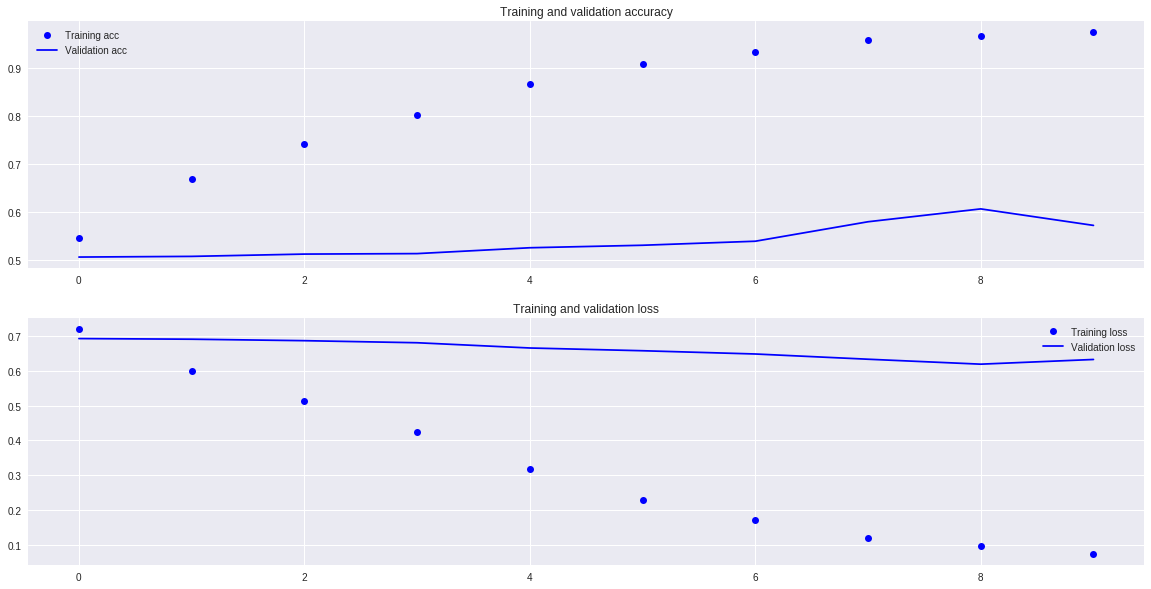

In [24]:
plot_history(history, samples=10)

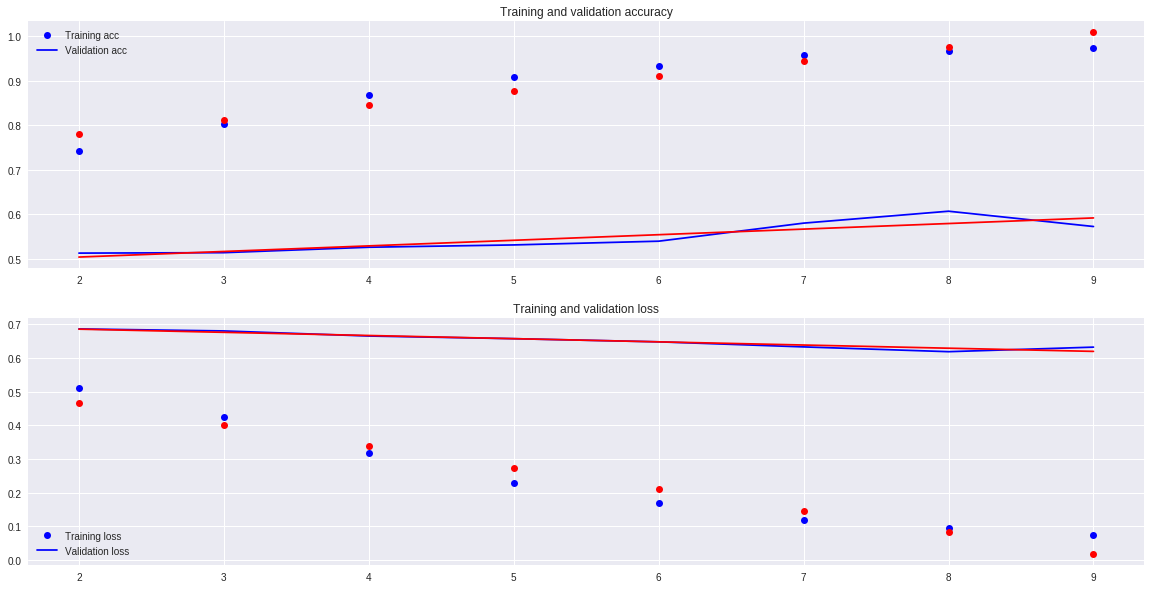

In [26]:
plot_history(history, samples=10, init_phase_samples=2, plot_line=True)